In [20]:
from functools import partial
from collections import OrderedDict


import torch
import torch.nn as nn
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

def drop_path(x, drop_prob: float = 0., training: bool = False):
    """
    Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).
    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.
    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    """
    Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)


class PatchEmbed(nn.Module):
    """
    2D Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_c=3, embed_dim=768, norm_layer=None):
        super().__init__()
        img_size = (img_size, img_size)
        patch_size = (patch_size, patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        self.num_patches = self.grid_size[0] * self.grid_size[1]

        self.proj = nn.Conv2d(in_c, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()

    def forward(self, x):
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."

        # flatten: [B, C, H, W] -> [B, C, HW]
        # transpose: [B, C, HW] -> [B, HW, C]
        x = self.proj(x).flatten(2).transpose(1, 2)
        x = self.norm(x)
        return x


class Attention(nn.Module):
    def __init__(self,
                 dim,   # 输入token的dim
                 num_heads=8,
                 qkv_bias=False,
                 qk_scale=None,
                 attn_drop_ratio=0.,
                 proj_drop_ratio=0.):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop_ratio)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop_ratio)

        self.attention_maps = None

    def forward(self, x):
        # [batch_size, num_patches + 1, total_embed_dim]
        B, N, C = x.shape

        # qkv(): -> [batch_size, num_patches + 1, 3 * total_embed_dim]
        # reshape: -> [batch_size, num_patches + 1, 3, num_heads, embed_dim_per_head]
        # permute: -> [3, batch_size, num_heads, num_patches + 1, embed_dim_per_head]
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        # [batch_size, num_heads, num_patches + 1, embed_dim_per_head]
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        # transpose: -> [batch_size, num_heads, embed_dim_per_head, num_patches + 1]
        # @: multiply -> [batch_size, num_heads, num_patches + 1, num_patches + 1]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        self.attention_maps = attn.detach()
        attn = self.attn_drop(attn)

        # @: multiply -> [batch_size, num_heads, num_patches + 1, embed_dim_per_head]
        # transpose: -> [batch_size, num_patches + 1, num_heads, embed_dim_per_head]
        # reshape: -> [batch_size, num_patches + 1, total_embed_dim]
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Mlp(nn.Module):
    """
    MLP as used in Vision Transformer, MLP-Mixer and related networks
    """
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Block(nn.Module):
    def __init__(self,
                 dim,
                 num_heads,
                 mlp_ratio=4.,
                 qkv_bias=False,
                 qk_scale=None,
                 drop_ratio=0.,
                 attn_drop_ratio=0.,
                 drop_path_ratio=0.,
                 act_layer=nn.GELU,
                 norm_layer=nn.LayerNorm):
        super(Block, self).__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
                              attn_drop_ratio=attn_drop_ratio, proj_drop_ratio=drop_ratio)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path_ratio) if drop_path_ratio > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop_ratio)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_c=3, out_chans=3,
                 embed_dim=768, depth=12, num_heads=12, mlp_ratio=4.0, qkv_bias=True,
                 qk_scale=None, representation_size=None, distilled=False, drop_ratio=0.,
                 attn_drop_ratio=0., drop_path_ratio=0., embed_layer=PatchEmbed, norm_layer=None,
                 act_layer=None, dropcls=0):
        """
        Args:
            img_size (int, tuple): input image size
            patch_size (int, tuple): patch size
            in_c (int): number of input channels
            num_classes (int): number of classes for classification head
            embed_dim (int): embedding dimension
            depth (int): depth of transformer
            num_heads (int): number of attention heads
            mlp_ratio (int): ratio of mlp hidden dim to embedding dim
            qkv_bias (bool): enable bias for qkv if True
            qk_scale (float): override default qk scale of head_dim ** -0.5 if set
            representation_size (Optional[int]): enable and set representation layer (pre-logits) to this value if set
            distilled (bool): model includes a distillation token and head as in DeiT models
            drop_ratio (float): dropout rate
            attn_drop_ratio (float): attention dropout rate
            drop_path_ratio (float): stochastic depth rate
            embed_layer (nn.Module): patch embedding layer
            norm_layer: (nn.Module): normalization layer
        """
        super(VisionTransformer, self).__init__()
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
   
        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)
        act_layer = act_layer or nn.GELU

        self.patch_embed = embed_layer(img_size=img_size, patch_size=patch_size, in_c=in_c, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_ratio)

        self.h = img_size // patch_size
        self.w = img_size // patch_size

        dpr = [x.item() for x in torch.linspace(0, drop_path_ratio, depth)]  # stochastic depth decay rule
        self.blocks = nn.Sequential(*[
            Block(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                  drop_ratio=drop_ratio, attn_drop_ratio=attn_drop_ratio, drop_path_ratio=dpr[i],
                  norm_layer=norm_layer, act_layer=act_layer)
            for i in range(depth)
        ])
        self.norm = norm_layer(embed_dim)

        # Representation layer
        self.pre_logits = nn.Sequential(OrderedDict([
            ('conv1', nn.ConvTranspose2d(embed_dim, out_chans*16, kernel_size=(2, 2), stride=(2, 2))),
            ('act1', nn.Tanh()),
            ('conv2', nn.ConvTranspose2d(out_chans*16, out_chans*4, kernel_size=(2, 2), stride=(2, 2))),
            ('act2', nn.Tanh())
            # ('transposeconv3', nn.ConvTranspose2d(out_chans * 4, out_chans, kernel_size=(4, 4), stride=(4, 4)))
        ]))

        self.head = nn.ConvTranspose2d(out_chans*4, out_chans, kernel_size=(4, 4), stride=(4, 4))

        if dropcls > 0:
            print('dropout %.2f before classifier' % dropcls)
            self.final_dropout = nn.Dropout(p=dropcls)
        else:
            self.final_dropout = nn.Identity()


        trunc_normal_(self.pos_embed, std=.02)
        self.apply(_init_vit_weights)

    def forward_features(self, x):
        '''
        patch_embed:
        [B, T, C, H, W] -> [B*T, num_patches, embed_dim]
        '''
        B,T,C,H,W = x.shape
        B = x.shape[0]
        x = x.view(B, T*C, H, W)
        
        x = self.patch_embed(x)  
        x = self.pos_drop(x + self.pos_embed)
        x = self.blocks(x)
        x = self.norm(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x).transpose(1, 2)
        x = torch.reshape(x, [-1, self.embed_dim, self.h, self.w])
        return x

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = self.forward_features(x)
        x = self.final_dropout(x)
        x = self.pre_logits(x)
        x = self.head(x) 
        x = x.reshape(B, T, C, H, W)
        return x
    
def _init_vit_weights(m):
    """
    ViT weight initialization
    :param m: module
    """
    if isinstance(m, nn.Linear):
        nn.init.trunc_normal_(m.weight, std=.01)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode="fan_out")
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LayerNorm):
        nn.init.zeros_(m.bias)
        nn.init.ones_(m.weight)

In [21]:
import torch

img_size = 64
patch_size = 16
in_c = 1 
out_c = 1
embed_dim = 256  
depth = 1
num_heads = 1
mlp_ratio = 4.0  
betch_size = 10
time_step = 10

vit_model = VisionTransformer(
    img_size=img_size,
    patch_size=patch_size,
    in_c=in_c * time_step,
    out_chans=out_c * time_step,
    embed_dim=embed_dim,
    depth=depth,
    num_heads=num_heads,
    mlp_ratio=mlp_ratio
)

input = torch.randn(betch_size, time_step, in_c, img_size, img_size)
print("input shape:", input.shape)
output = vit_model(input)

print("output shape:", output.shape)

input shape: torch.Size([10, 10, 1, 64, 64])
output shape: torch.Size([10, 10, 1, 64, 64])


In [22]:
# 提取attention map
attention_maps = vit_model.blocks[0].attn.attention_maps
print(attention_maps.shape)

torch.Size([10, 1, 16, 16])


In [23]:
import torch
import torch.nn as nn
import numpy as np
import random
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import scipy.io as sio


class NS2DDataset1e5(Dataset):
    def __init__(self, data_path, transform=None):
        self.metadata = sio.loadmat(data_path)
        self.data = self.metadata["u"]
        self.data = torch.from_numpy(self.data)
        self.data = self.data.permute(0, 3, 1, 2)
        self.data.unsqueeze_(2)  # 在通道维度上添加一个维度
        self.transform = transform
        self.mean = torch.mean(self.data)
        self.std = torch.std(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_frames = self.data[idx][:10]
        output_frames = self.data[idx][10:]

        input_frames = (input_frames - self.mean) / self.std
        output_frames = (output_frames - self.mean) / self.std

        return input_frames, output_frames

def load_data(batch_size, val_batch_size, data_root, num_workers):
    train_dataset = NS2DDataset1e5(data_path=data_root + 'train_data.mat', transform=None)
    test_dataset = NS2DDataset1e5(data_path=data_root + 'test_data.mat', transform=None)
    dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True,
                                  num_workers=num_workers)
    dataloader_validation = DataLoader(test_dataset, batch_size=val_batch_size, shuffle=False, pin_memory=True,
                                       num_workers=num_workers)
    dataloader_test = DataLoader(test_dataset, batch_size=val_batch_size, shuffle=False, pin_memory=True,
                                 num_workers=num_workers)

    mean, std = train_dataset.mean, train_dataset.std
    return dataloader_train, dataloader_validation, dataloader_test, mean, std

In [24]:
if __name__ == '__main__':
    dataloader_train, dataloader_validation, dataloader_test, mean, std = load_data(batch_size=10, 
                                                                                    val_batch_size=10, 
                                                                                    data_root='/data/workspace/yancheng/MM/neural_manifold_operator/data/',
                                                                                    num_workers=8)
    for input_frames, output_frames in iter(dataloader_train):
        print(input_frames.shape, output_frames.shape)
        break


torch.Size([10, 10, 1, 64, 64]) torch.Size([10, 10, 1, 64, 64])


In [25]:
# import torch

# img_size = 128
# patch_size = 16 
# in_c = 2  
# out_c = 2
# embed_dim = 512  
# depth = 1
# num_heads = 1 
# mlp_ratio = 4.0  
# betch_size = 1
# time_step = 10

# vit_model = VisionTransformer(
#     img_size=img_size,
#     patch_size=patch_size,
#     in_c=in_c,
#     out_chans=out_c,
#     embed_dim=embed_dim,
#     depth=depth,
#     num_heads=num_heads,
#     mlp_ratio=mlp_ratio
# )


# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
vit_model.to(device)

optimizer = torch.optim.Adam(vit_model.parameters(), lr=0.001)
mse_loss = nn.MSELoss()

def validate_model(model, dataloader_valid, mse_loss):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for input_frames, output_frames in dataloader_valid:
            input_frames = input_frames.to(device)
            output_frames = output_frames.to(device)
            preds = model(input_frames)
            loss = mse_loss(preds, input_frames)
            total_loss += loss.item()
    return total_loss / len(dataloader_valid)

def train_model(model, dataloader_train, dataloader_valid, optimizer, mse_loss, epochs=10):
    min_valid_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        for input_frames, output_frames in dataloader_train:
            input_frames = input_frames.to(device)
            output_frames = output_frames.to(device)

            optimizer.zero_grad()
            preds = model(input_frames)
            loss = mse_loss(preds, input_frames)
            loss.backward()
            optimizer.step()

        valid_loss = validate_model(model, dataloader_valid, mse_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {loss.item()}, Valid Loss: {valid_loss}")

        # Save the best model
        if valid_loss < min_valid_loss:
            min_valid_loss = valid_loss
            torch.save(model.state_dict(), '2024big_best_model.pth')
            print("Model saved")


train_model(vit_model, dataloader_train, dataloader_validation, optimizer, mse_loss, epochs=2)

Using device: cuda
Epoch 1/10, Train Loss: 0.028955062851309776, Valid Loss: 0.023487855214625597
Model saved
Epoch 2/10, Train Loss: 0.015158561989665031, Valid Loss: 0.0157769447658211
Model saved
Epoch 3/10, Train Loss: 0.009921854361891747, Valid Loss: 0.011371599091216923
Model saved
Epoch 4/10, Train Loss: 0.008600796572864056, Valid Loss: 0.00967515294905752
Model saved
Epoch 5/10, Train Loss: 0.008311229757964611, Valid Loss: 0.008315125340595841
Model saved
Epoch 6/10, Train Loss: 0.006396039389073849, Valid Loss: 0.007357743522152305
Model saved
Epoch 7/10, Train Loss: 0.007163625210523605, Valid Loss: 0.006274342723190785
Model saved
Epoch 8/10, Train Loss: 0.00701170414686203, Valid Loss: 0.005856031901203096
Model saved
Epoch 9/10, Train Loss: 0.006358802318572998, Valid Loss: 0.005973610025830567
Epoch 10/10, Train Loss: 0.004328057169914246, Valid Loss: 0.00521638672798872
Model saved


In [38]:
# 实例化
# import torch

# img_size = 128
# patch_size = 16 
# in_c = 2  
# out_c = 2
# embed_dim = 512  
# depth = 1
# num_heads = 1 
# mlp_ratio = 4.0  
# betch_size = 1
# time_step = 10

# vit_model = VisionTransformer(
#     img_size=img_size,
#     patch_size=patch_size,
#     in_c=in_c * time_step,
#     out_chans=out_c * time_step,
#     embed_dim=embed_dim,
#     depth=depth,
#     num_heads=num_heads,
#     mlp_ratio=mlp_ratio
# )
device = torch.device('cpu')
# print(f"Using device: {device}")
# vit_model.to(device)

# optimizer = torch.optim.Adam(vit_model.parameters(), lr=0.001)
# mse_loss = nn.MSELoss()
def test_model(model, dataloader_test, mse_loss):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for input_frames, output_frames in dataloader_test:
            input_frames = input_frames.to(device)
            output_frames = output_frames.to(device)
            preds = model(input_frames)
            np.save('preds.npy', preds.cpu())
            np.save('labels.npy', input_frames.cpu())
    #         loss = mse_loss(preds, input_frames)
    #         total_loss += loss.item()
    # print(f"Test Loss: {total_loss / len(dataloader_test)}")

best_model = vit_model 
best_model.load_state_dict(torch.load('/data/workspace/yancheng/MM/causal_physical_system/big_best_model.pth'))
test_model(best_model, dataloader_test, mse_loss)

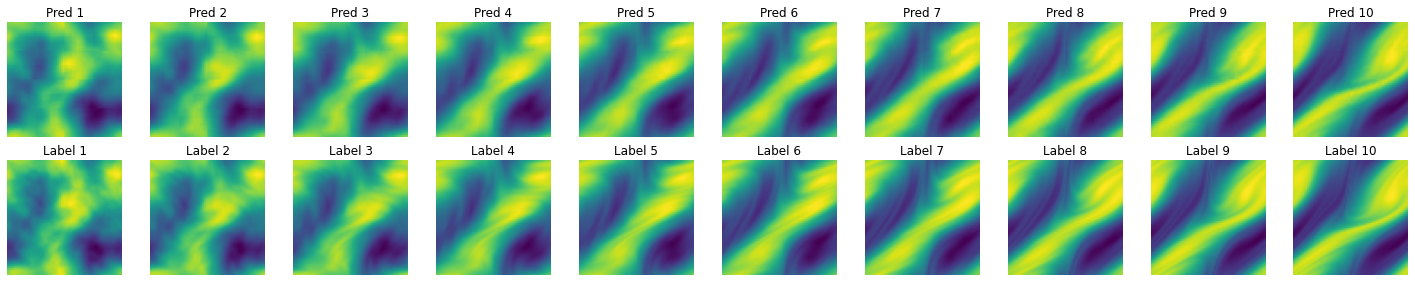

In [39]:
# vis
import numpy as np
import matplotlib.pyplot as plt

preds = np.load('preds.npy')

labels = np.load('labels.npy')

# Reshape the arrays as mentioned
preds = preds[0:1, :, :, :, :]
labels = labels[0:1, :, :, :, :]

# Print out the shapes to verify
preds_shape = preds.shape
labels_shape = labels.shape

# Visualizing the predictions and labels
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

for i in range(10):
    # Plot predictions
    axes[0, i].imshow(preds[0, i, 0, :, :], cmap=None)
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Pred {i+1}')

    # Plot labels
    axes[1, i].imshow(labels[0, i, 0, :, :], cmap=None)
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Label {i+1}')

plt.tight_layout()
plt.show()

In [40]:
attention_maps = vit_model.blocks[0].attn.attention_maps
print(attention_maps.shape)

torch.Size([10, 1, 16, 16])


8


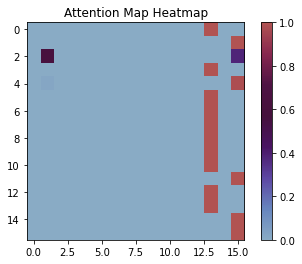

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib as mpl
import random



mycolor=['#89ABC5','#6785BE','#5D46A3','#491463','#45113C','#4E1344','#87274F','#B15352']
cmap_color = mpl.colors.LinearSegmentedColormap.from_list('my_list', mycolor)
cmap = cmap_color

batch_index = random.randint(0, 10)
print(batch_index)
attention_map = attention_maps[batch_index][0]
attention_map = attention_map.cpu()
plt.imshow(attention_map, cmap=cmap)
plt.colorbar()
plt.title('Attention Map Heatmap')
plt.show()

(16, 16)


(array([ 0,  8, 13, 14,  7]),
 array([5.034071e-06, 6.568710e-05, 5.985657e-02, 6.999934e+00,
        8.940138e+00], dtype=float32),
 array([ 2, 10,  9, 12,  5]),
 array([0.0000000e+00, 0.0000000e+00, 1.3252521e-38, 3.2802725e-28,
        1.8725915e-23], dtype=float32))

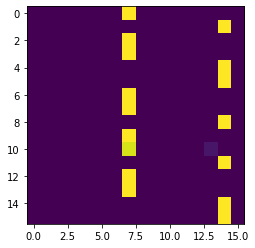

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import random

time_index = 0
attentionmap = attention_maps[time_index][0]
attentionmap = attentionmap.cpu().detach().numpy()
print(attentionmap.shape)
plt.imshow(attentionmap)
column_sums = np.sum(attentionmap, axis=0)
largest_indices = np.argsort(column_sums)[-5:]
smallest_indices = np.argsort(column_sums)[:5]
largest_sums = column_sums[largest_indices]
smallest_sums = column_sums[smallest_indices]
largest_indices, largest_sums, smallest_indices, smallest_sums

In [31]:
lambdas = 0.1
encoder1 = vit_model = VisionTransformer(
    img_size=img_size,
    patch_size=patch_size,
    in_c=in_c * time_step,
    out_chans=out_c * time_step,
    embed_dim=embed_dim,
    depth=depth,
    num_heads=num_heads,
    mlp_ratio=mlp_ratio
)

encoder2 = vit_model = VisionTransformer(
    img_size=img_size,
    patch_size=patch_size,
    in_c=in_c * time_step,
    out_chans=out_c * time_step,
    embed_dim=embed_dim,
    depth=depth,
    num_heads=num_heads,
    mlp_ratio=mlp_ratio
)
output1_causal = encoder1(input) # x
output2_nocausal = encoder2(input) # y

def Infonce_loss(x,y):
    return x+y

def mse_loss(x,y):
    return 0

def decoder(x):
    return x

outputs = output1_causal + output2_nocausal
output_all = decoder(outputs)
loss_infonce = Infonce_loss(output1_causal, output2_nocausal) 
loss_rec = mse_loss(output_all, label)
loss_all =  lambdas * loss_infonce + (1-lambdas) * loss_rec

NameError: name 'label' is not defined

In [ ]:
# 提取attention map
attention_maps_causal = encoder1.blocks[0].attn.attention_maps
attention_maps_no_causal = encoder2.blocks[0].attn.attention_maps
print(attention_maps_causal.shape)
print(attention_maps_no_causal.shape)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

time_index = 0
attentionmap = attention_maps_causal[time_index][0]
attentionmap = attentionmap.cpu().detach().numpy()
print(attentionmap.shape)
plt.imshow(attentionmap)
column_sums = np.sum(attentionmap, axis=0)
largest_indices = np.argsort(column_sums)[-5:]
smallest_indices = np.argsort(column_sums)[:5]
largest_sums = column_sums[largest_indices]
smallest_sums = column_sums[smallest_indices]
largest_indices, largest_sums, smallest_indices, smallest_sums

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

time_index = 0
attentionmap = attention_maps_no_causal[time_index][0]
attentionmap = attentionmap.cpu().detach().numpy()
print(attentionmap.shape)
plt.imshow(attentionmap)
column_sums = np.sum(attentionmap, axis=0)
largest_indices = np.argsort(column_sums)[-5:]
smallest_indices = np.argsort(column_sums)[:5]
largest_sums = column_sums[largest_indices]
smallest_sums = column_sums[smallest_indices]
largest_indices, largest_sums, smallest_indices, smallest_sums